Описание проблемы:  
**Точки сращивания** - это такие точки на цепочке ДНК, участки ДНК между которыми помечаются "лишними" и удаляются в процессе синтеза белка в высших организмах.  
**Экзоном** называется участок ДНК, сохраненный в результирующей цепочке после сращивания.  
**Интроном** называется участок ДНК, который был подвергнут сплавлению и не вошёл в результирующую последовательность ДНК.  
Проблему распознания таких участков можно разбить на 2 части:  
    -распознавание границ экзона/интрона (EI -sites) - так называемых доноров  
    -распознавание границ интрона/экзона (IE -sites) - так называемых акцепторов

Категории доноров и акцепторов включают в себя все "разделяющие гены" для приматов, хранящиеся в Банке Генов 64.1
Несращиваемые (N) примеры взяты из последовательностей, про которые известно, что они не содержат сращивающейся части

Будем рассматривать участки ДНК длиной 60 нуклеотидов начиная от -30 и заканчивая +30; каждое поле в данной цепочке может быть заполнено:  
    - Явно указанным нуклеотидом (Аденин - A, Тимин - T, Гуанин - G, Цитозин - C)  
    - Неявно указанным нуклеотидом в соответствии с таблицей:  
        D: A или G или T
        N: A или G или C или T
        S: C или G
        R: A или G

Начнём с того, что загрузим библиотеки, которые будем в дальнейшем использовать для обработки данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Загрузим набор данных из файла   
Отметим, что в данных, по сути, содержится 62 атрибута:   
        -класс (акцептор, донор, несращиваемый),  
        -имя гена,   
        -последовательность из 60 нуклеотидов   

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
data = pd.read_csv('../splice.data', sep = ', ', engine = 'python')

Внимательно посморев на множество данных, сделаем вывод о том, что мы будем решать задачу классификации:  
    определять тип имеющегося перехода на участке ДНК по самой последовательности нуклеотидов

In [3]:
data.describe()

,Type,Donor,DNA
count,3190,3190,3190
unique,3,3178,3092
top,N,HUMMYLCA-ACCEPTOR-924,GGAAGATGCTGGAGGAGAAACCCTGGGAAGGTAGG...
freq,1655,2,3


Выше - таблица с описанием множества данных

Необходимо отметить, что границы области сращивания определяются следующим образом:  
    Вариант 1: EI - граница - определена короткой последовательностью и отсутствием стоп-кодона (останавливающего триплета) на стороне экзона   
    
	EI :- @-3 'MAGGTRAGT', not(EI-stop)  

Вариант 2: EI - граница строится на основе стоп-кодона в некоторой окрестности окончания части экзона  
    
	EI-stop ::- @-3 'TAA'.      
	EI-stop ::- @-3 'TAG'.      
	EI-stop ::- @-3 'TGA'.      
	EI-stop ::- @-4 'TAA'.  
    EI-stop ::- @-4 'TAG'.      
    EI-stop ::- @-4 'TGA'.      
    EI-stop ::- @-5 'TAA'.      
    EI-stop ::- @-5 'TAG'.      
    EI-stop ::- @-5 'TGA'.
    

Для границы интрон-экзон существует 2 варианта определения:  
    Вариант 1: Граница интрон - экзон определяется короткой последовательностью вокруг границы, отсутствием «стоп-кодона» сразу после границы и «насыщенной пирамидином» области, предшествующей границе.
    
   	IE :- pyramidine-rich, @-3 'YAGG', not(IE-stop).  
   	pyramidine-rich :- 6 of (@-15 'YYYYYYYYYY').  

Вариант 2: явное указание стоп-кодона в некоторой окрестности окончания части экзона

   	 IE-stop1 ::- @1 'TAA'.  
   	 IE-stop2 ::- @1 'TAG'.  
   	 IE-stop3 ::- @1 'TGA'.  
        IE-stop4 ::- @2 'TAA'.  
        IE-stop5 ::- @2 'TAG'.  
        IE-stop6 ::- @2 'TGA'.  
        IE-stop7 ::- @3 'TAA'.  
        IE-stop8 ::- @3 'TAG'.  
        IE-stop9 ::- @3 'TGA'.  


Итак, в данном наборе нас интересуют:   

        -относительная частота нуклеотидов;  
        -разбиение на классы относительно сращивания последовательностей ДНК;  
        -способ определения границы сращивания (по стоп-кодону или без него, тип стоп-кодона (если есть))  

Подготовим множество нуклеотидов (возможных встречающихся в ДНК)  
Отметим, что варианты "значений", которые может принимать нуклеотид, взяты из описания исходного множества данных

In [4]:
nucleotids =['A','T','G','C','D','N','R','S']
for i in nucleotids:
    data[i]=0

Заполним количество нуклеотидов каждого вида для каждой цепочки ДНК:


In [5]:
for i in range(len(data)):
    for nc in nucleotids:
        data[nc][i] = data['DNA'][i].count(nc)

Определим, какой стоп-кодон используется в данной последовательности, учитывая:

        если класс = n, стоп-кодона нет  
        иначе ищем стоп-кодон (будем учитывать, что окрестность точки сплавления составляет 5 нуклеотид, поэтому стоп-кодон не может располагаться на +30 или -30 позиции)

В правилах определения стоп-кодона на границе области сращивания указано, что он может принимать 3 разных значения:  

    триплет Тимин-Аданин-Аданин  
    триплет Тимин-Аденин-Гуанин  
    триплет Тимин-Гуанин-Аденин  
    
Кроме того, на участке ДНК, независимо от его типа, может не быть стоп-кодона

In [6]:
stop_codones = ['TAA', 'TAG', 'TGA']
data['stop-code']='None'
for i in range(len(data)):
    if data['Type'][i]!= 'N':
        for j in range(len(stop_codones)): 
            stopcd = data['DNA'][i].find(stop_codones[j], 5, 59-5 )
            if stopcd != -1:
                if data['Type'][i]!='IE':
                    data['stop-code'][i]= stop_codones[j]
                    break;
                else:
                    priamidin = stopcd-15
                    pmd_start = min(data['DNA'][i].find('T', priamidin, stopcd), data['DNA'][i].find('C', priamidin, stopcd))
                    if (data['DNA'][i][pmd_start:stopcd].count('T')+data['DNA'][i][pmd_start:stopcd].count('C')+ data['DNA'][i][pmd_start:stopcd].count('D')+data['DNA'][i][pmd_start:stopcd].count('S')+data['DNA'][i][pmd_start:stopcd].count('N')>=3):
                        data['stop-code'][i]= stop_codones[j]
                        
                        break;

Посмотрим на результаты поиска стоп-кодов по всему множеству данных  
Отметим, что половина данных (1655 строк таблицы) отосятся к участкам ДНК без перехода через точку сращивания, 
таким образом, всего 430 отрезков с точкой сращивания не содержат стоп-кодона 

In [7]:
data['stop-code'].describe()

count     3190
unique       4
top       None
freq      2085
Name: stop-code, dtype: object

Подсчитаем частоту встречаемости стоп-кодов

In [8]:
st = data['stop-code'].unique()
stop_code_freq = [0 for i in range (len(st))]
for j in range(len(data)):
    for i in range (len(st)):
        if data['stop-code'][j]==st[i]:
            stop_code_freq[i]=stop_code_freq[i]+1
stop_code_freq

[2085, 448, 411, 246]

Для наглядности построим график частоты встречемости стоп-кодонов  
Используем функцию bar библиотеки matplotlib.pyplot, в качестве входных параметров передадим размещение для каждой группы (позицию столбца), количество наблюдений для каждого варианта стоп-кодона (значение для каждого столбца), ширину каждого из столбцов  
Добавим подписи по осям

([<matplotlib.axis.XTick at 0x626ae71198>,
 <a list of 4 Text xticklabel objects>)

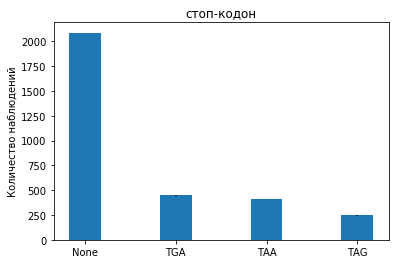

In [9]:
stpcdnStd = (1,2,3,4)
ind = np.arange(len(stop_code_freq))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, stop_code_freq, width, yerr=stpcdnStd)

plt.ylabel('Количество наблюдений')
plt.title('стоп-кодон')
plt.xticks(ind, st)

График количества наблюдений стоп-кодонов на множестве данных

В биологии принято считать, что нуклеотиды попарно комплиментарны друг другу  
Так, напротив Аденина, расположенного на определенной позиции в одной нити ДНК, на данной же позиции во второй нити расположен Тимин, Напротив Гуанина - Цитозин. Этот механизм необходим для репликации ДНК при синтезе белка посредством РНК (рибо-нуклеиновой кислоты): спираль ДНК разкручивается, и транспортная РНК на основе принципа комплементарности пиримидиновых и азотистых оснований собирает "зеркальную копию" нити ДНК, собирая и состыковывая нуклеотиды как бусины на нитку до тех пор, пока не встретит управляющую последовательность (стоп-триплет или стоп-кодон). Синтез белка останавливается, нити ДНК снова скручиваются, а к скопированной нити создаётся её "зеркальная копия".  
Поэтому нам интересна зависимость частоты встречаемости комплементарных нуклеотидов, построим соответствующие графики.  
Здесь мы воспользуемся функцией plot из той же библиотеки, что и выше, на вход - количество нуклеотид из соответствующей комплементарной пары (образуется точка на плоскости с соответствующими координатами)

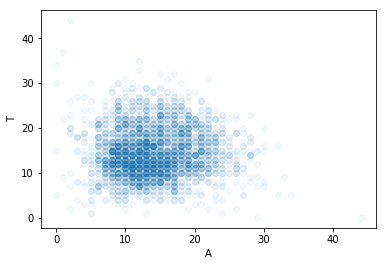

In [10]:
plt.plot(data['A'], data['T'], 'o', alpha = 0.05)
plt.xlabel('A')
plt.ylabel('T')
pass

График наблюдений количества нуклеотидов Аденина и Тимина в отрезках ДНК длиной 60 нуклеотид

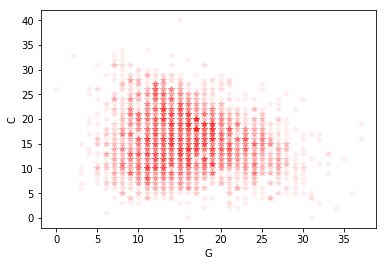

In [11]:
plt.plot(data['G'], data['C'], '*', alpha = 0.05, color = 'r')
plt.xlabel('G')
plt.ylabel('C')
pass

Выше - график наблюдений количества нуклеотидов Цитозина и Гуанина в отрезках ДНК длиной 60 нуклеотид

Интересно взглянуть на среднюю частоту встречаемости для каждого нуклеотида по всему множеству данных

In [12]:
data.median(axis = 0)

A    13.0
T    14.0
G    15.0
C    15.0
D     0.0
N     0.0
R     0.0
S     0.0
dtype: float64

Постараемся определить корреляцию между имеющимися данными

In [13]:
data.corr()

,A,T,G,C,D,N,R,S
A,1.000000,0.021637,-0.317992,-0.587782,-0.019735,-0.031145,-0.013953,0.000192
T,0.021637,1.000000,-0.579559,-0.374532,-0.023977,-0.046278,0.018529,-0.011883
G,-0.317992,-0.579559,1.000000,-0.143892,0.030838,-0.042843,-0.012116,-0.012116
C,-0.587782,-0.374532,-0.143892,1.000000,0.005407,-0.017196,0.003823,0.019337
D,-0.019735,-0.023977,0.030838,0.005407,1.000000,-0.000601,-0.000444,-0.000444
N,-0.031145,-0.046278,-0.042843,-0.017196,-0.000601,1.000000,-0.000425,-0.000425
R,-0.013953,0.018529,-0.012116,0.003823,-0.000444,-0.000425,1.000000,-0.000314
S,0.000192,-0.011883,-0.012116,0.019337,-0.000444,-0.000425,-0.000314,1.000000


Выше представлена таблица корреляции между количеством нуклеотидов каждого вида в множестве данных  
Оценим ее согласно приведенной таблицы:  

    Значение коэффициента корреляции r 	Интерпретация  
                        0 < г <= 0,2 	Очень слабая корреляция  
                        0,2 < г <= 0,5 	Слабая корреляция  
                        0,5 < г <= 0,7 	Средняя корреляция  
                        0,7 < г <= 0,9 	Сильная корреляция  
                        0,9 < г <= 1 	Очень сильная корреляция  
                        
 Отметим, что коэффициент корреляции может принимать значения в интервале [-1;1], а значения в таблице приведены по модулю  
    Kорреляция непосредственно между комплементарными нуклеотидами - слабая, а между некомплементарными - средняя, корреляция с вариативными нуклеотидами - практически отсутствует
   
   Отобразим полученные результаты вграфическом виде при помощи функции scatter_matrix из библиотеки pandas

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


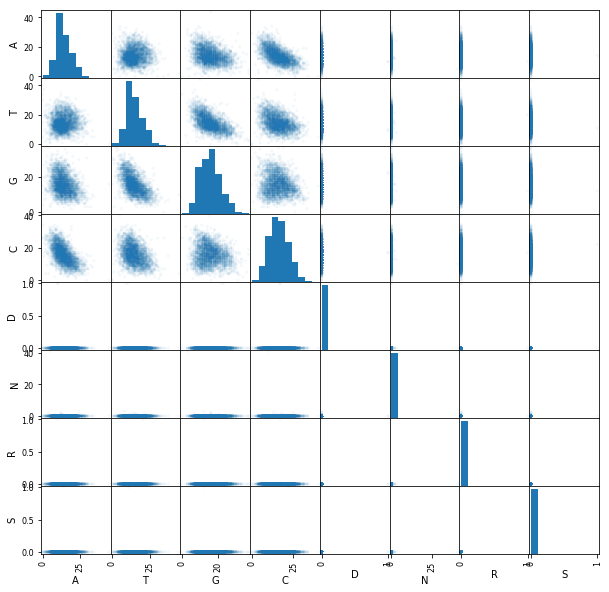

In [14]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data, alpha = .05, figsize = (10, 10))
pass

Графики, отображающие корреляцию в подготовленном множестве данных

Подготовим имеющиеся данные для работы с ними

В нашем множестве данных присутствуют как количественные, так и категориальные столбцы с данными:  
    первые содержат численное значение, вторые - некоторое строковое, характеризующее данную запись в таблице
Поскольку с категориальными столбцами работать не слишком удобно, хотелось бы изменить их и привести к количественному или бинарному виду  
Поскольку в исходном наборе данных есть два категорильных столбца с высокой ~100% степенью уникальности значений, описывающих имя донора цепочки ДНК и сам отрезок ДНК, мы не будем включать их в результирующий набор  
К бинарным столбцам мы отнесем те бывшие категориальные, где принимаемые значения можно записать в виде 0 или 1:  
Например, тип границы сращивания (нет границы или есть, граница интрон-экзн или нет, граница экзон-интрон или нет)

In [15]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object' and c!='Donor' and c!='DNA']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
data_describe = data.describe(include = [object])
print(categorical_columns)
print(numerical_columns)
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)
data_nonbinary = pd.get_dummies(data[categorical_columns])
print(data_nonbinary.columns)

['Type', 'stop-code']
['A', 'T', 'G', 'C', 'D', 'N', 'R', 'S']
[] ['Type', 'stop-code']
Index(['Type_EI', 'Type_IE', 'Type_N', 'stop-code_None', 'stop-code_TAA',
       'stop-code_TAG', 'stop-code_TGA'],
      dtype='object')


К количественным столбцам в нашем случае относятся только столбцы частоты встречаемости нуклеотида в отрезке ДНК

In [16]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,A,T,G,C,D,N,R,S
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,13.945768,14.516614,15.750784,15.768025,0.000627,0.017555,0.000313,0.000313
std,5.008604,5.241326,5.482687,5.707964,0.025035,0.731630,0.017705,0.017705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,14.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,18.000000,19.000000,20.000000,0.000000,0.000000,0.000000,0.000000
max,44.000000,44.000000,37.000000,40.000000,1.000000,41.000000,1.000000,1.000000


Таблица, содержащая информацию о данныч из количественных столбцов множества

Для удобства и простоты работы хотелось бы такие значения нормализовать
Кроме того, заметим, что в нашем наборе отсутствуют пропущенные значения, что не может не радовать))

In [17]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [18]:
data_numerical.describe()

,A,T,G,C,D,N,R,S
count,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03
mean,-1.405006e-16,2.143879e-17,4.750641e-17,4.161422e-16,-2.984051e-16,4.191005e-16,-1.934777e-16,-1.934777e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.784362e+00,-2.769645e+00,-2.872822e+00,-2.762461e+00,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02
25%,-7.877980e-01,-6.709398e-01,-6.841142e-01,-6.601347e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02
50%,-1.888287e-01,-9.856559e-02,-1.369372e-01,-1.345532e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02
75%,6.097971e-01,6.646000e-01,5.926321e-01,7.414158e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02
max,6.000521e+00,5.625176e+00,3.875694e+00,4.245292e+00,3.991867e+01,5.601524e+01,5.646238e+01,5.646238e+01


Выше - таблица, содержащая информацию данных в количественных столбцах множества после нормирования

Теперь объединим обе части таблицы (количественную и бывшую категориальную в одну)

In [19]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)


In [20]:
data.describe()

,A,T,G,C,D,N,R,S,Type_EI,Type_IE,Type_N,stop-code_None,stop-code_TAA,stop-code_TAG,stop-code_TGA
count,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,-1.405006e-16,2.143879e-17,4.750641e-17,4.161422e-16,-2.984051e-16,4.191005e-16,-1.934777e-16,-1.934777e-16,0.240439,0.240752,0.518809,0.653605,0.128840,0.077116,0.140439
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.427417,0.427607,0.499724,0.475895,0.335075,0.266817,0.347496
min,-2.784362e+00,-2.769645e+00,-2.872822e+00,-2.762461e+00,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.877980e-01,-6.709398e-01,-6.841142e-01,-6.601347e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.888287e-01,-9.856559e-02,-1.369372e-01,-1.345532e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,6.097971e-01,6.646000e-01,5.926321e-01,7.414158e-01,-2.504308e-02,-2.399417e-02,-1.770536e-02,-1.770536e-02,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,6.000521e+00,5.625176e+00,3.875694e+00,4.245292e+00,3.991867e+01,5.601524e+01,5.646238e+01,5.646238e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Выше - информация об общей подготовленной таблице с данными, предназначенными для классификации

Поскольку перед нами стоит задача классификации, создадим столбец, указывающий к какому классу (ei,ie,n) относится данная строка в таблице
Разобъём множество данных на тестовую и обучающую выборки

In [21]:
X = data
Y = [0 for i in range(len(data))]
for i in range(len(data)):
    if data['Type_EI'][i]==1:
        Y[i]=1
    if data['Type_IE'][i]==1:
        Y[i]=2
    if data['Type_N'][i]==1:
        Y[i]=3
feature_names = X.columns
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size = 0.3, random_state = 1)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

2233 957


In [22]:
X_test

,A,T,G,C,D,N,R,S,Type_EI,Type_IE,Type_N,stop-code_None,stop-code_TAA,stop-code_TAG,stop-code_TGA
1675,-0.388485,1.236974,0.957417,-1.711298,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0
1002,0.010828,-1.052523,-0.319330,1.266997,-0.025043,-0.023994,-0.017705,-0.017705,0,1,0,1,0,0,0
2708,-0.987454,-0.861731,0.775024,0.916610,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0
13,0.010828,0.283017,0.592632,-0.835329,-0.025043,-0.023994,-0.017705,-0.017705,1,0,0,0,0,0,1
45,-0.388485,-0.289357,0.957417,-0.309747,-0.025043,-0.023994,-0.017705,-0.017705,1,0,0,0,0,0,1
2684,-0.787798,-0.861731,-0.136937,1.617385,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0
2682,-0.987454,-0.289357,-0.319330,1.442191,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0
2087,-0.588142,1.046183,0.227847,-0.660135,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0
282,-1.586424,-1.434105,2.051771,0.741416,-0.025043,-0.023994,-0.017705,-0.017705,1,0,0,0,0,0,1
2256,-0.987454,1.427766,-0.684114,0.215834,-0.025043,-0.023994,-0.017705,-0.017705,0,0,1,1,0,0,0


Выше - таблица с подготовленными данными для тестирования работы модели

Итак, приступим!
Первый метод классификации - метод k ближайших соседей из библиотеки sklearn
Обучим нашу модель и посмотрим на результаты работы

In [23]:
from sklearn import neighbors
from sklearn.cross_validation import train_test_split

model = neighbors.KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Ошибка классификации составила ~1%
Неплохо!

In [24]:
from sklearn import metrics
print (1 - metrics.accuracy_score(y_test, y_test_pred))


0.00104493207941


Для наглядности построим матрицу смешивания
И заметим, что некоторое количество объектов класса ei было ошибочно классифицировано как n

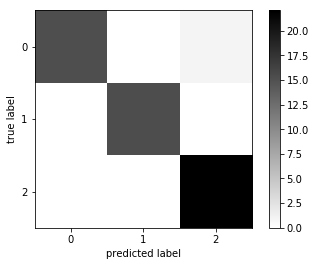

In [25]:
M = metrics.confusion_matrix(y_test, y_test_pred)
#M = M - np.diag(np.diag(M))
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.grid(False)
plt.xticks(range(3))
plt.yticks(range(3))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.colorbar()

Кроме того, интересно посмотреть, как будет меняться ошибка на тестовой и обучающей выборках с увеличением числа соседей для модели

In [26]:
kk = range(1, 30, 2)
err_train = []
err_test = []
for k in kk:
    model = neighbors.KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(np.mean(model.predict(X_train) != y_train))
    err_test.append(np.mean(model.predict(X_test) != y_test))

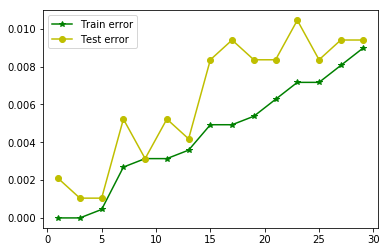

In [27]:
plt.plot(kk, err_train, '*-g', label = 'Train error')
plt.plot(kk, err_test,  'o-y', label = 'Test error')    
plt.legend(loc = 2)

Как мы видим из графика, с увеличением числа ближайших соседей ошибка растет и при 23 соседях достигает максимума на тестовой выборке в 10%

Теперь на тех же самых выборках обучим модель LDA, и сравним полученные результаты

In [28]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Как мы видим, ошибка классификации при использовании данной модели составила ~24%  
Интересно посмотреть, что же произошло, для этого построим матрицу смешивания

In [29]:
y_test_pred = lda_model.predict(X_test)
np.mean(y_test != y_test_pred)

0.24242424242424243

In [30]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test, y_test_pred))


[[198  19  17]
 [ 74  44 119]
 [  0   3 483]]


И отобразим полученный график

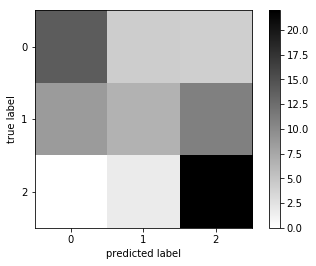

In [31]:
M = confusion_matrix(y_test, y_test_pred)
#M = M - np.diag(np.diag(M))
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.grid(False)
plt.xticks(range(3))
plt.yticks(range(3))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.colorbar()

Исходя из графического отображения матрицы смешивания на рисунке выше, некоторое количество объектов класса ei были ошибочно отнесены к классу ie, меньшее количество объектов класса ie ошибочно классифицированы как ei и n и, наконец, значительное количество (~15%) объектов класса n причислены к классу ie, ~5%  объектов n классифицированы как ei

Воспользуемся методом квадратичного дискриминантного анализа на всё тех же начальных выборках, обучим модель и оценим ошибку

In [32]:
qda_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

y_test_pred = qda_model.predict(X_test)

np.mean(y_test != y_test_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


0.49216300940438873

Честно говоря, когда модель при классификации ошибается в половине случаев, всякое желание использовать её отпадает... 

А пока что проверим, как проявит себя метод логистической регрессии в условиях данной задачи.  
Всё в точном соответствии с пунктами, описанными выше: на имеющихся выборках обучаем модель, предсказываем значения, вычисляем ошибку классификации

In [33]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_test_pred = logistic_model.predict(X_test)
np.mean(y_test != y_test_pred)

0.0

Ошибка классификации - 0%!!! Что-то весьма невероятное и приятно-неожиданное
Особенно в контрасте с полученной на прошлом шаге ошибкой в 49%.
Строим матрицу смешивания и ещё раз восхищаемся

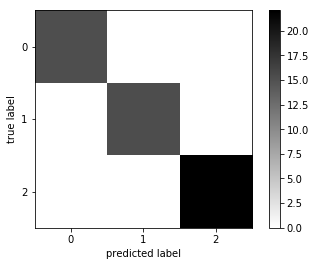

In [34]:
M = confusion_matrix(y_test, y_test_pred)
#M = M - np.diag(np.diag(M))
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.grid(False)
plt.xticks(range(3))
plt.yticks(range(3))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.colorbar()

Продолжаем тестировать применение различных методов классификации на наших данных. На очереди - машина опорных векторов

In [35]:
from sklearn.svm import SVC # "Support Vector Classifier"
svc_model = SVC(kernel = 'linear')
svc_model.fit(X_test, y_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Посмотрим на ошибку классификации при использовании данной модели

In [36]:
y_test_pred = svc_model.predict(X_test)
np.mean(y_test != y_test_pred)

0.0

И снова - все объекты классифицированы верно, ошибка равна 0%
Полагаю, что матрица смешивания в данном случае не столь интересна)

Остался нерассмотренным последний метод - наивный Баессовский классификатор.
Рассмотрим два варианта: Гауссов и Бернулле классификаторы

In [37]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_test, y_test)


GaussianNB(priors=None)

In [38]:
err_train = np.mean(y_train != gnb_model.predict(X_train))
err_test = np.mean(y_test != gnb_model.predict(X_test))
print(err_train, err_test)

0.000447828034035 0.0


Полученная ошибка на обучающей выборке и на тестовой выборке приблизительно 0%

In [39]:
from sklearn.naive_bayes import BernoulliNB
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [40]:
err_train = np.mean(y_train != nb_model.predict(X_train))
err_test = np.mean(y_test != nb_model.predict(X_test))
print(err_train, err_test)

0.0 0.0


По аналогии с примером выше, ошибка 0%

Выводы: 

        -На рассматриваемом наборе данных лучше все себя показали метод линейной регрессии и наивный Баессовский классификатор, при использовании которых ошибка классификации составила 0%  
        -метод k ближайших соседей показал себя весьма неплохо при малых значениях k, соответственно, проблема выбора оптимального числа соседей сохраняется;  
        -линейный и квадратичный дискриминантные анализы классифицировали объекты с достаточно большой ошибкой, более того, последний определял класс объекта с точность 50%, т.е ошибался в половине случаев, соответственно, его использование на указанных данных нецелесообразно.

Теперь перейдём к следующей части изучения работы методов классификации на примере участков ДНК. Основная задача - научиться относить цепочку нуклеотид к одному из трёх классов: содержащую участок перехода от включаемого в основную (кодирующую) последовательность к исключаемому при ретрансляции участку; участок перехода от исключаемого к кодирующему участку ДНК; участок без переходов (т.е целиком относящийся к кодирующему (чаще всего) или исключаемому участку ДНК - наиболее частая длина исключаемого участка - 4-5 аминокислот, т.е. до 20 нуклеотид.  
На подготовительном этапе перед проведением данного изучения точности классификации было замечено, что существует прямая зависимость между имеющимися данными и классом, к которому относится участок ДНК. Поэтому, для чистоты эксперимента, удалим данные столбцы; позднее на полученных данных снова протестируем методы из числа рассмотренных ранее, которые показали наилучшие результаты.

In [42]:
X = X.drop(['Type_N', 'Type_IE','Type_EI'], axis =1) 
X_train = X_train.drop(['Type_N', 'Type_IE','Type_EI'], axis=1) 
X_test = X_test.drop(['Type_N', 'Type_IE','Type_EI'], axis =1) 

Для начала, применим к нашим данным метод ансамблей деревьев решений. Размер тренировочной выборки составляет приблизительно треть от начальной выборки. Поскольку на размер ошибки влияет количество "экспертов", принимающих участие в голосовании, рассмотрим несколько вариантов и сделаем выводы об оптимальном числе деревьев применительно к имеющимся данным.

Сначала обучим модель для 15 деревьев и оценим результаты работы.

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
rf_model = ExtraTreesClassifier(n_estimators=15)
rf_model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
err_train = np.mean(y_train != rf_model.predict(X_train))
err_test = np.mean(y_test != rf_model.predict(X_test))
print(err_train, err_test)

0.0273175100761 0.188087774295


Ошибка на тренировочной выборке составила ~3%, на тестовой ~19%, что само по себе достаточно неплохо. Посмотрим динамику изменения величины ошибки при росте числа "экспертов"

In [45]:
kk = range(10, 30, 1)
err_train = []
err_test = []
err_general = []

for k in kk:
    model =rf_model = ExtraTreesClassifier(n_estimators=k)
    model.fit(X_train, y_train)
    err_train.append(np.mean(model.predict(X_train) != y_train))
    err_test.append(np.mean(model.predict(X_test) != y_test))
    err_general.append(np.mean(model.predict(X) != Y))
    

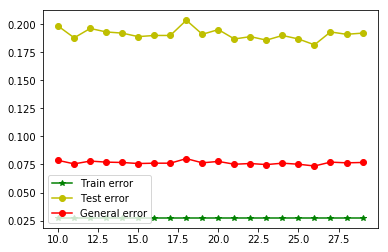

In [46]:
plt.plot(kk, err_train, '*-g', label = 'Train error')
plt.plot(kk, err_test,  'o-y', label = 'Test error') 
plt.plot(kk, err_general, 'o-r', label = 'General error')
plt.legend(loc = 3)

Глядя на график, можно сделать следующие выводы:  
1) Тренировочная ошибка была постоянна на уровке 2.7%   
2) Наилучшие показатели тестовой ошибки были получены при 26 деревьях в ансамбле   
3) Общая ошибка по выборке была практически стабильна (за счёт того, что тестовая выборка составляет всего треть от всей совокупности и не было значительных скачков в величине тестовой ошибки)

Теперь воспользуемся методом адаптивного бустинга:   
Заметим, что в нашей модели более 2 классов, поэтому для классификации будет использоваться алгоритм SAMME   
Сначала посмотрим результаты при 50 "экспертах", а затем в динамике от 20 до 50.

In [47]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [48]:
err_train = np.mean(y_train != ada_model.predict(X_train))
err_test = np.mean(y_test != ada_model.predict(X_test))
print(err_train, err_test)

0.274070756829 0.272727272727


Классификатор ошибается чаще, чем рассмотренный ранее ансамбль деревьев. Особенно это заметно по ошибке на тренировочной выборке. Тем интереснее сравнить результаты работы для моделей с разным числом классификаторов (fm):

In [49]:
kk = range(20, 50, 1)
err_train = []
err_test = []
err_general = []

for k in kk:
    model = AdaBoostClassifier(n_estimators = k)
    model.fit(X_train, y_train)
    err_train.append(np.mean(model.predict(X_train) != y_train))
    err_test.append(np.mean(model.predict(X_test) != y_test))
    err_general.append(np.mean(model.predict(X) != Y))

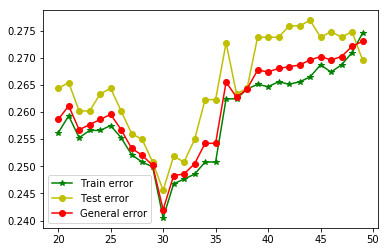

In [50]:
plt.plot(kk, err_train, '*-g', label = 'Train error')
plt.plot(kk, err_test,  'o-y', label = 'Test error') 
plt.plot(kk, err_general, 'o-r', label = 'General error')
plt.legend(loc = 3)

Уже интереснее - наиболее точно данная модель работает при 30 классификаторах. На этих графиках уже прослеживается влияние тестовой ошибки на общую ошибку. Тем не менее, ансамбль деревеьв решений более точно определял класс, к которому относится участок ДНК.

Метод градиентного спуска интересен с той точки зрения, что величина ошибки может зависеть как от числа классификаторов, так и от глубины спуска. Возьмём число классификаторов от 20 до 50, глубину спуска от 3 до 5 и приготовимся наблюдать.

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_model = GradientBoostingClassifier()
gbt_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [52]:
err_train = np.mean(y_train != gbt_model.predict(X_train))
err_test = np.mean(y_test != gbt_model.predict(X_test))
print(err_train, err_test)

0.150470219436 0.215256008359


Исходя из полученных результатов, для 100 "экспертов" и глубины спуска = 3, полученная ошибка лучше, чем при адаптивном бустинге. Теперь подготовим данные для построения графиков.

In [53]:
from random import randint
kk = range(20, 50, 1)
err_train_3 = []
err_test_3 = []
err_general_3 = []

err_train_4 = []
err_test_4 = []
err_general_4 = []

err_train_5 = []
err_test_5 = []
err_general_5 = []

for k in kk:
    model = GradientBoostingClassifier(n_estimators = k, max_depth = 3)
    model.fit(X_train, y_train)
    err_train_3.append(np.mean(model.predict(X_train) != y_train))
    err_test_3.append(np.mean(model.predict(X_test) != y_test))
    err_general_3.append(np.mean(model.predict(X) != Y))
    
    model = GradientBoostingClassifier(n_estimators = k, max_depth = 3)
    model.fit(X_train, y_train)
    err_train_4.append(np.mean(model.predict(X_train) != y_train))
    err_test_4.append(np.mean(model.predict(X_test) != y_test))
    err_general_4.append(np.mean(model.predict(X) != Y))
    
    model = GradientBoostingClassifier(n_estimators = k, max_depth = 3)
    model.fit(X_train, y_train)
    err_train_5.append(np.mean(model.predict(X_train) != y_train))
    err_test_5.append(np.mean(model.predict(X_test) != y_test))
    err_general_5.append(np.mean(model.predict(X) != Y))

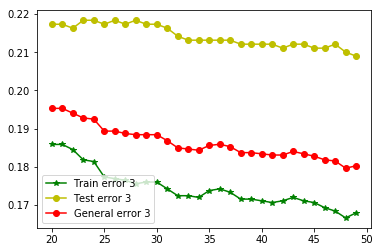

In [54]:
plt.plot(kk, err_train_3, '*-g', label = 'Train error 3')

plt.plot(kk, err_test_3,  'o-y', label = 'Test error 3') 
plt.plot(kk, err_general_3, 'o-r', label = 'General error 3')
plt.legend(loc = 3)

Исходя из полученноо графика для глубины спуска = 3, с возрастанием количества классификаторов ошибка снижается и достигает минимума при 48 классификаторах. Вспомним, что для 100 "экспертов" было получено значение 15% ошибки для обучающей выборки, отсюда делаем вывод, что минимум на 48 "экспертах" является локальным.

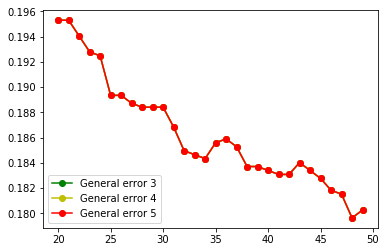

In [58]:
plt.plot(kk, err_general_3, 'o-g', label = 'General error 3')
plt.plot(kk, err_general_4,  'o-y', label = 'General error 4') 
plt.plot(kk, err_general_5, 'o-r', label = 'General error 5')
plt.legend(loc = 3)

На данном рисунке мы видим только красный график, хотя отрисованы все три графика. Отсюда делаем вывод о независимости результатов классификции наших данных методом градиентного спуска от глубины спуска.

Теперь применим метод главных компонент; интересно, сколько же столбцов - признаков останется в данных, если не внести никаких ограничений модели.

In [71]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca)

[[  1.25565675   0.21984029  -0.95422243 ...,  -3.82745367   1.36665552
   -3.04696444]
 [  0.68861321   0.47737679  -1.73149275 ...,  -2.39540684   1.36665552
   -0.91417528]
 [ -0.98155136  -0.34550526   1.37251637 ...,   2.27980487   2.88159766
   -5.08280864]
 ..., 
 [ -0.75840269   0.18867099  -0.66779593 ...,   1.92179316  -0.79754753
    2.76973326]
 [  0.73186889   0.13519722  -0.57248382 ...,  -1.72150245   4.6129601
   -6.24614818]
 [  1.63848637   0.32516361  -1.09914747 ...,  -5.80704782   6.34432255
  -10.89950634]]


In [72]:
len(X_train.columns)

12

Интересное наблюдение: все 12 столбцов, которые остались в данных после удаления 3 столбцов, явно указывающих на класс, вошли в отобранные при помощи метода главных компонент. Отсюда делаем вывод, что сокращать размерность пространства признаков просто некуда.

Как и было указано выше, прогоним повторное тестирование для некоторых методов, рассмотренных в первой части - а именно, для метода опорных векторов, входящего в число показавших наилучшие результаты, и для линейного дискриминантного анализа, закоремендовавшего себя не самым лучшим образом.

In [73]:
from sklearn.svm import SVC # "Support Vector Classifier"
svc_model = SVC(kernel = 'linear')
svc_model.fit(X_test, y_test)
y_test_pred = svc_model.predict(X_test)
np.mean(y_test != y_test_pred)

0.20480668756530826

Вот теперь получено более реальное значение ошибки, значительно отличающееся от нуля!

In [74]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_test_pred = lda_model.predict(X_test)
np.mean(y_test != y_test_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.24242424242424243

Полученная ошибка не изменилась по сравнению с предыдущим случаем использования линейного дискриминантного анализа. Кроме того, мы снова получили предупреждение, что переменные коллинеарны, что означает достаточно сильную корреляцию между столбцами - признаками данных. Тем не менее, метод главных компонент не исключил ни одного столбца из данных. 

Наконец, посмотрим на изменение значений ошибки для ансамбля деревьев решений при сокращении размерности пространства признаков. Пусть их количество меняется от 2 до 12

In [82]:
from sklearn.decomposition import PCA
err_train = []
err_test = []

for i in range (2,12):
    pca = PCA(n_components = i, whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    model = ExtraTreesClassifier(n_estimators = 26)
    model.fit(X_train_pca, y_train)
    err_train.append(np.mean(model.predict(X_train_pca) != y_train))
    err_test.append(np.mean(model.predict(X_test_pca) != y_test))


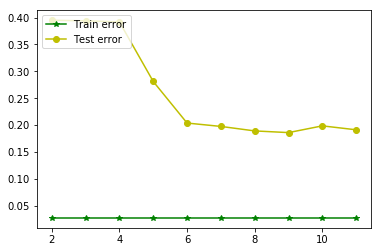

In [83]:
kk = range(2,12, 1)
plt.plot(kk, err_train, '*-g', label = 'Train error')
plt.plot(kk, err_test,  'o-y', label = 'Test error') 
plt.legend(loc = 2)

Исходя из графика, можно сделать вывод, что по меньшей мере 6 признаков нужны для того, чтобы снизить ошибку вдвое по срвнению с ошибкой при 2 признаках.

Выводы:   
Исключение некоторых столбцов, непосредственно указывающих на класс, привело к тому, что точность классификации уменьшилась и стала более реальной;  
из сохранившихся параметров не удалось исключить не участвующие в классификации по причине отсутствия таковых;   
Среди проверенных во второй части методов средняя ошибка ~20%, наилучшим образом себя зарекомендовали метод ансамблей деревьев решений и метод градиентного спуска с минимальной ошибкой на тестовой выборке в 18%.   
Применение машины опорных векторов на уменьшенном пространстве признаков показало вполне ожидаемый рост ошибки классификации, последняя на тестовой выборке составила 20%. Это говорит о том, что результаты, полученные в первой части работы, стоит перепроверить, предположительно ошибка составит около 20%. Ошибка, полученная при использовании адаптивного бустинга, даже больше, чем при использовании линейного дискриминантного анализа, который мы сочли не самым подходящим для классификации в первой части работы.   
Интересно ещё и то, что часть методов, рассмотренных до деревьев решений, даже со столбцами, явно и однозначно указывающими на класс, к которому относится данная последовательность нуклеотид, кодирующая участок ДНК, не смогла это "увидеть" и, соответственно, воспользоваться. Из методов, рассмотренных во второй части, минимальная ошибка на тестовой выборке составила около 18%. Средняя около 20%, отсюда делаем вывод, что любая модель, дающая более 80% верных указаний класса, может быть применима к используемым данным.   
Лично для меня оказалось наиболее применимым использование ансамблей деревьев решений, потому что метод градиентного спуска заставил ноутбук основательно "задуматься" на сравнительно большой промежуток времени (по сравнению с прочими моделями).